In [100]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from sklearn.cluster import KMeans
import imageio
import os
import copy

In [5]:
X = np.array([
    [1] * 6,
    [1] * 6,
    [1] * 6,
    [2] * 6,
    [2] * 6,
    [2] * 6,
    [3] * 6,
    [3] * 6,
    [3] * 6,
])

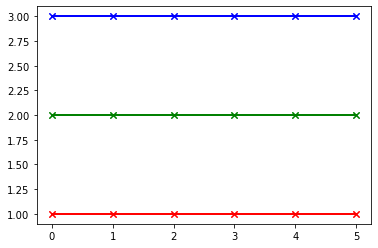

In [6]:
plt.plot(range(6), X[0], marker='x', c='r')
plt.plot(range(6), X[1], marker='x', c='r')
plt.plot(range(6), X[2], marker='x', c='r')
plt.plot(range(6), X[3], marker='x', c='g')
plt.plot(range(6), X[4], marker='x', c='g')
plt.plot(range(6), X[5], marker='x', c='g')
plt.plot(range(6), X[6], marker='x', c='b')
plt.plot(range(6), X[7], marker='x', c='b')
plt.plot(range(6), X[8], marker='x', c='b')
plt.show()

In [7]:
dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([9, 1, 6])

In [8]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,3,1)
        self.max_pool = nn.MaxPool1d(2,1)
        self.lstm_hidden_dim = 1
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=1,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        x = self.max_pool(F.relu(self.cnn(x)))
        x = x.permute(0, 2, 1)
        x, (_, _) = self.lstm(x)

        x = x[:, :, : self.lstm_hidden_dim] + x[:, :, self.lstm_hidden_dim :]
        x = x.permute(0,2,1)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Make each time series have 4 elements
        self.upsample = nn.Upsample(size=(4,))
        self.decoder = nn.ConvTranspose1d(1,1,3,1)
    
    def forward(self,x):
        x = self.upsample(x)
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime


class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(9,3)

        for i in range(9):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P)

In [9]:
def train_TAE(ae, n_epochs):
    optimizer = optim.Adam(ae.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.5,
        patience=50,
        threshold=0.001
    )

    latents = []
    losses = [] 

    pbar = tqdm(range(n_epochs))

    for i in pbar:
        l, x_prime = ae(dataset)
        loss = criterion(x_prime, dataset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sheduler.step(loss.item())

        latents.append(l.detach().numpy())
        losses.append(loss.item())
        
        if i % 100 == 0:
            pbar.set_description(f'{round(loss.item(), 6)}')
    return latents, losses

In [347]:
encoder_full = Encoder()
decoder_full = Decoder()
ae_full = TAE(encoder_full, decoder_full)

latents_full, losses_full = train_TAE(ae_full, n_epochs=10000)

0.212527: 100%|██████████| 10000/10000 [00:18<00:00, 549.92it/s]


In [378]:
decoder_partial = Decoder()
encoder_paritial = Encoder()
ae_partial = TAE(encoder_paritial, decoder_partial)

latents_partial, losses_partial = train_TAE(ae_partial, n_epochs=5000)

0.654959: 100%|██████████| 5000/5000 [00:09<00:00, 541.21it/s]


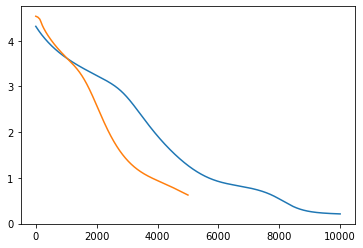

In [379]:
plt.plot(range(len(losses_full)), losses_full)
plt.plot(range(len(losses_partial)), losses_partial)
plt.show()

In [393]:
ls = [i.squeeze(1) for i in latents_full]

100%|██████████| 10000/10000 [00:03<00:00, 2866.82it/s]


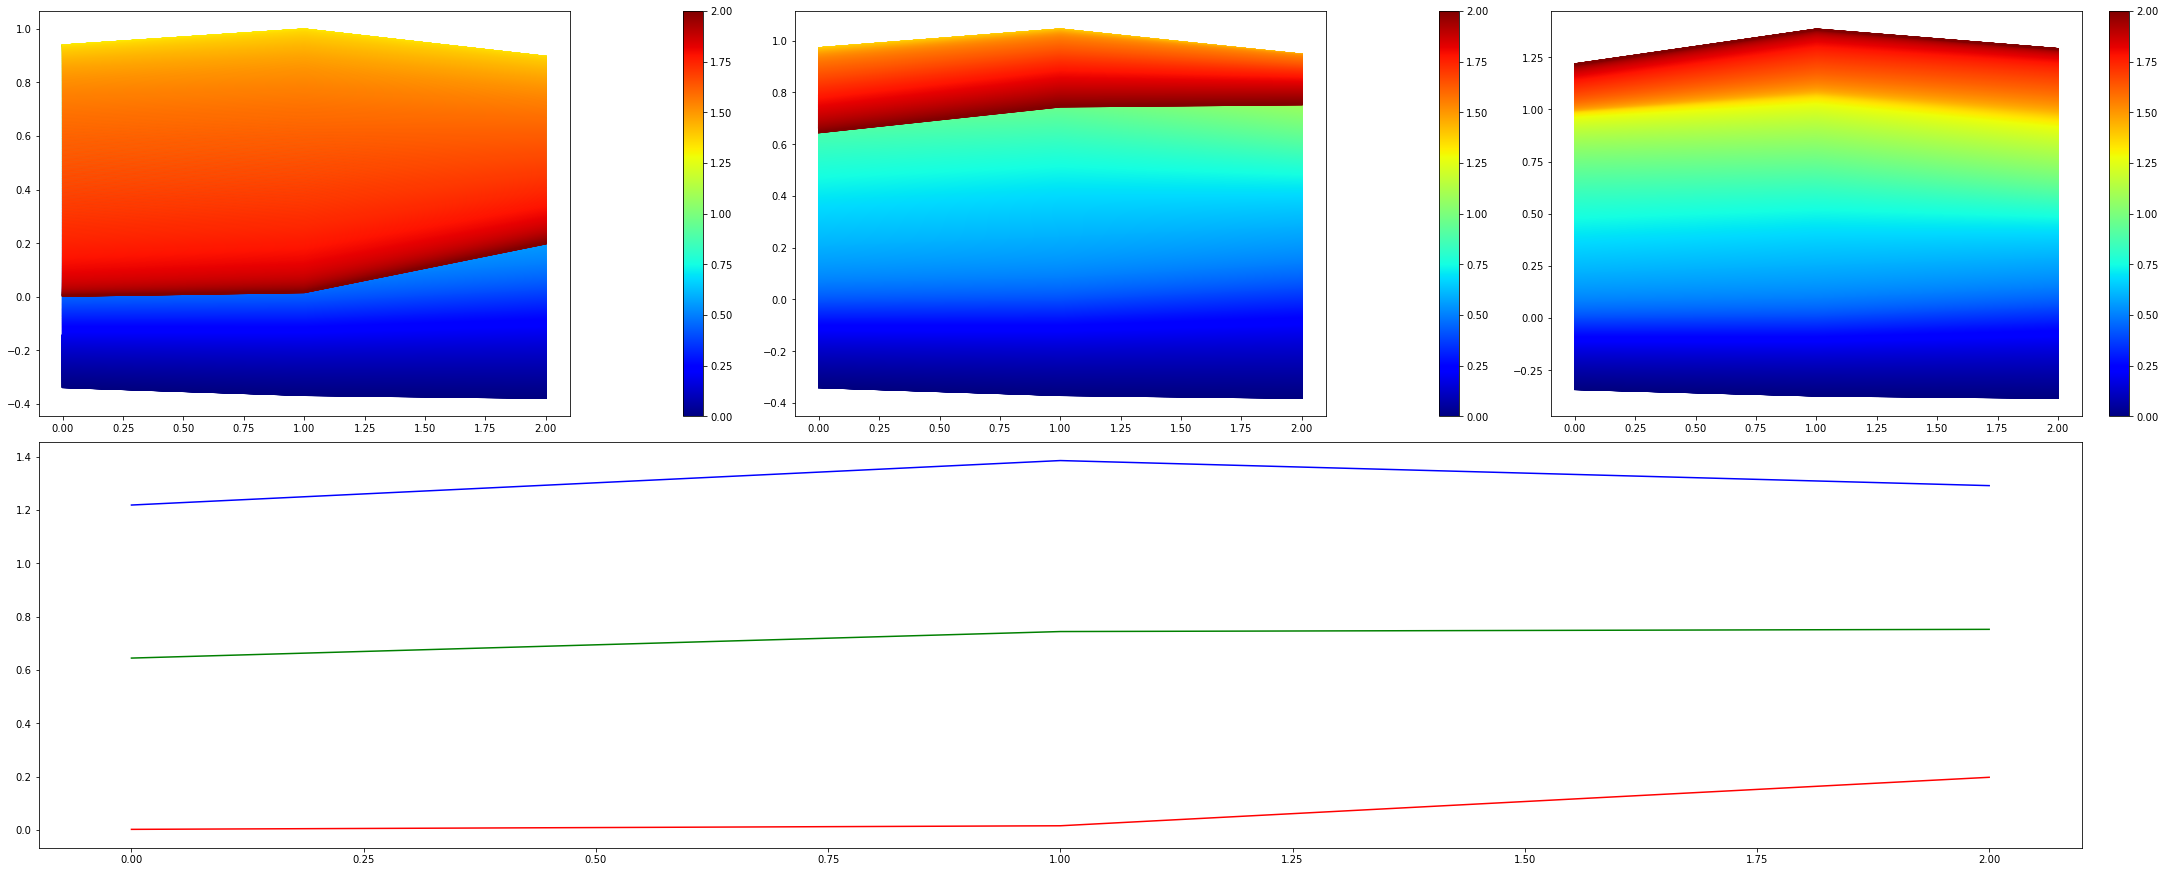

In [359]:
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

cmap = plt.get_cmap('jet', 10000)

for i in tqdm(range(10000)):
    if i < 1000:
        for j in range(3):
            ax1.plot(range(3), ls[i][j], c=cmap(i))
            ax2.plot(range(3), ls[i][j + 3], c=cmap(i))
            ax3.plot(range(3), ls[i][j + 6], c=cmap(i))
    elif i % 10 == 0:
        for j in range(3):
            ax1.plot(range(3), ls[i][j], c=cmap(i))
            ax2.plot(range(3), ls[i][j + 3], c=cmap(i))
            ax3.plot(range(3), ls[i][j + 6], c=cmap(i))


ax4.plot(range(3), ls[-1][0], c='r')
ax4.plot(range(3), ls[-1][3], c='g')
ax4.plot(range(3), ls[-1][6], c='b')


norm = matplotlib.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax1)
plt.colorbar(sm, ax=ax2)
plt.colorbar(sm, ax=ax3)

plt.gcf().set_size_inches(30,12)
plt.show()

In [380]:
ls = [i.squeeze(1) for i in latents_partial]

100%|██████████| 5000/5000 [00:08<00:00, 622.22it/s]


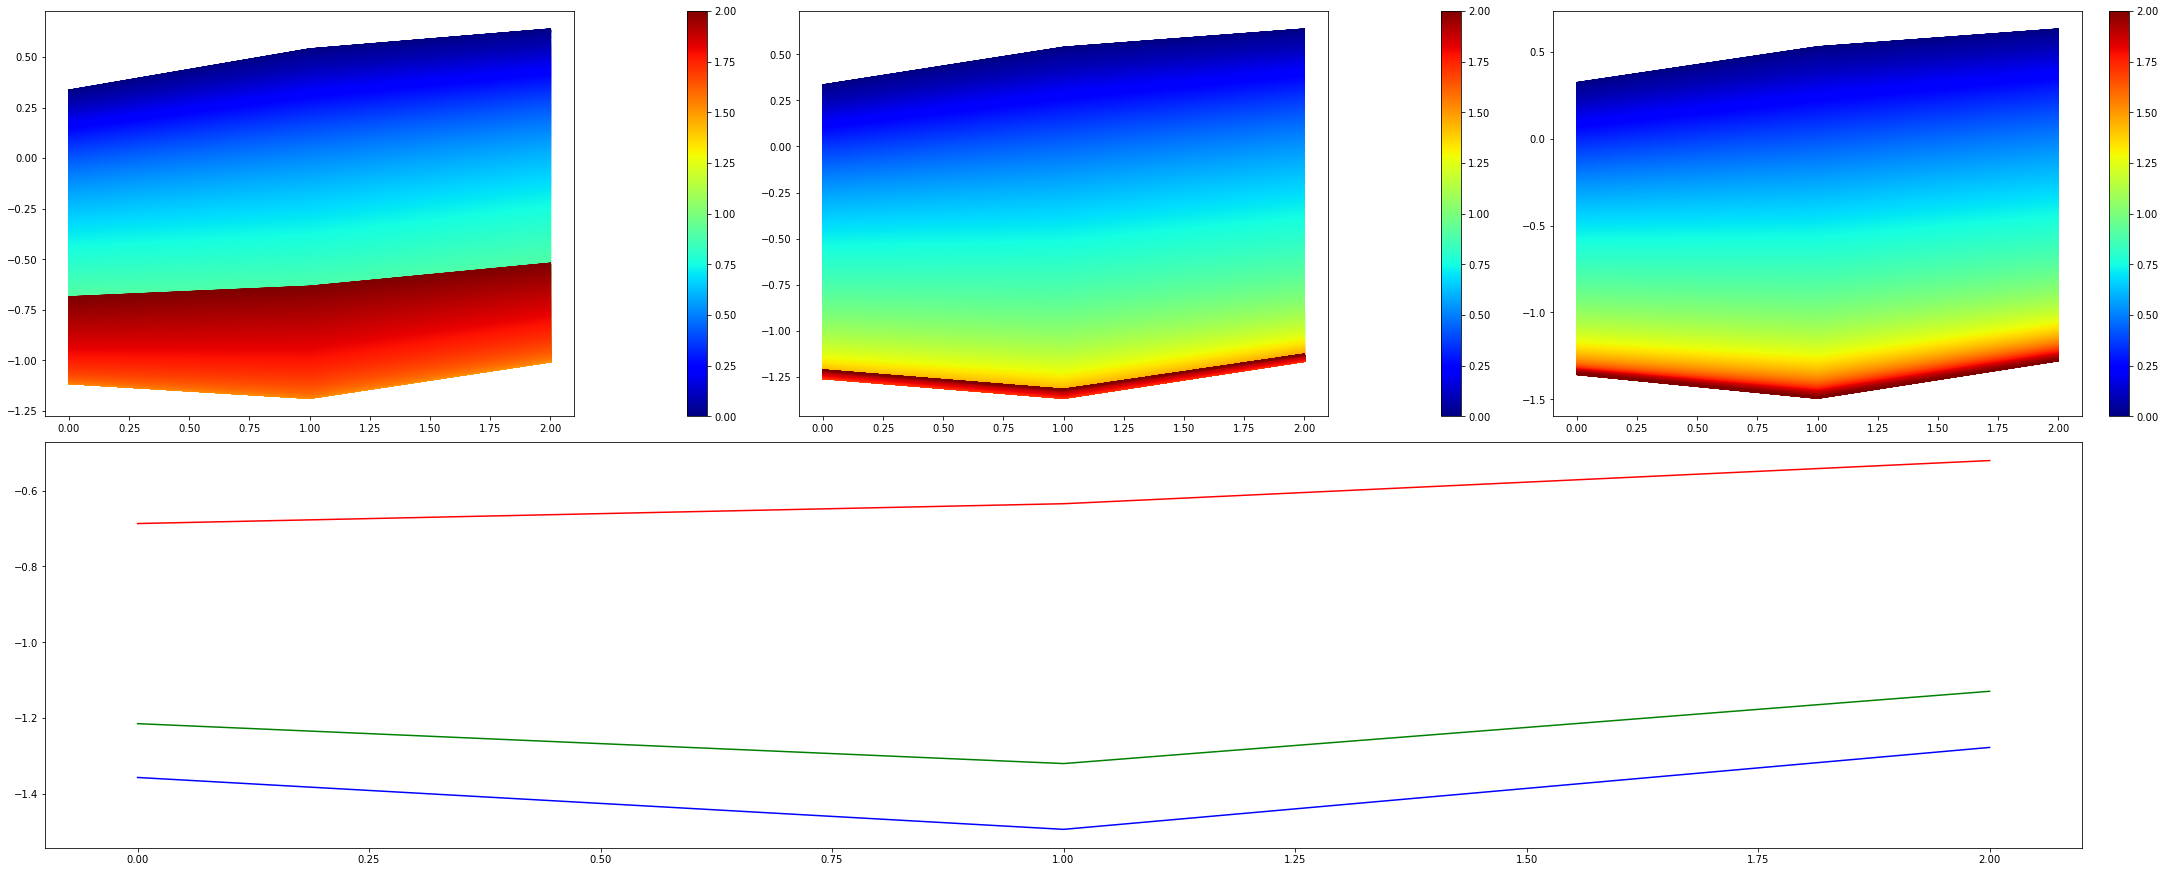

In [381]:
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

cmap = plt.get_cmap('jet', len(latents_partial))

for i in tqdm(range(len(latents_partial))):
    for j in range(3):
        ax1.plot(range(3), ls[i][j], c=cmap(i))
        ax2.plot(range(3), ls[i][j + 3], c=cmap(i))
        ax3.plot(range(3), ls[i][j + 6], c=cmap(i))
 

ax4.plot(range(3), ls[-1][0], c='r')
ax4.plot(range(3), ls[-1][3], c='g')
ax4.plot(range(3), ls[-1][6], c='b')

norm = matplotlib.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax1)
plt.colorbar(sm, ax=ax2)
plt.colorbar(sm, ax=ax3)

plt.gcf().set_size_inches(30,12)
plt.show()

In [10]:
def get_centroids(ae):
    l, x_prime = ae(dataset)
    cs = KMeans(n_clusters=3).fit_predict(l.detach().numpy().squeeze(1))

    centroids = []

    for i in range(3):
        mask = cs == i
        centroids.append(l[mask].mean(dim=2).reshape(1, -1))
    return torch.cat(centroids).detach()

In [402]:
centroids_full = get_centroids(ae_full)

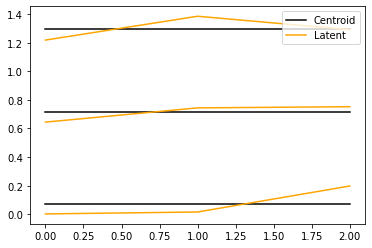

In [404]:
ls = [i.squeeze(1) for i in latents_full]
plt.plot(range(3), centroids_full[0], c='black', label='Centroid')
plt.plot(range(3), centroids_full[1], c='black')
plt.plot(range(3), centroids_full[2], c='black')

plt.plot(range(3), ls[-1][0], c='orange', label='Latent')
plt.plot(range(3), ls[-1][3], c='orange')
plt.plot(range(3), ls[-1][6], c='orange')

plt.legend()
plt.show()

In [406]:
centroids_partial = get_centroids(ae_partial)

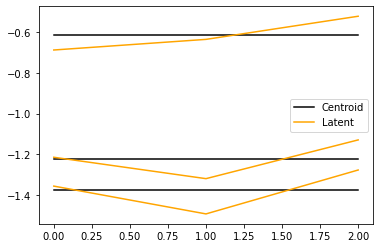

In [407]:
ls = [i.squeeze(1) for i in latents_partial]
plt.plot(range(3), centroids_partial[0], c='black', label='Centroid')
plt.plot(range(3), centroids_partial[1], c='black')
plt.plot(range(3), centroids_partial[2], c='black')

plt.plot(range(3), ls[-1][0], c='orange', label='Latent')
plt.plot(range(3), ls[-1][3], c='orange')
plt.plot(range(3), ls[-1][6], c='orange')

plt.legend()
plt.show()

In [11]:
def train_TAE(ae, n_epochs):
    optimizer = optim.Adam(ae.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.5,
        patience=50,
        threshold=0.001
    )

    latents = []
    losses = [] 

    pbar = tqdm(range(n_epochs))

    for i in pbar:
        l, x_prime = ae(dataset)
        loss = criterion(x_prime, dataset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sheduler.step(loss.item())

        latents.append(l.detach().numpy())
        losses.append(loss.item())
        
        if i % 100 == 0:
            pbar.set_description(f'{round(loss.item(), 6)}')
    return latents, losses

In [95]:
decoder = Decoder()
encoder = Encoder()
ae = TAE(encoder, decoder)

latents, losses = train_TAE(ae, n_epochs=5000)

0.076397: 100%|██████████| 5000/5000 [00:09<00:00, 526.85it/s]


In [96]:
centroids = get_centroids(ae)

In [97]:
centroids = centroids.unsqueeze(1)

In [98]:
centroids

tensor([[[-0.1025, -0.1025, -0.1025]],

        [[-0.9319, -0.9319, -0.9319]],

        [[ 0.7189,  0.7189,  0.7189]]])

In [102]:
cl_main = ClusterLayer(encoder=encoder, centroids=centroids)

In [106]:
cl = copy.deepcopy(cl_main)

In [107]:
optimizer = optim.SGD(cl.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
mse = nn.MSELoss()
kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

In [108]:
filenames = []
mse_data = []
kl_data = []
ls = []
cents = []

last_loss = float('inf')
tol = 0.00001
patience_counter = 0
patience_tol = 1000

pbar = tqdm(range(100000))

for i in pbar:
    l, P, Q = cl(dataset)
    x_prime = decoder(l)

    mse_loss = mse(dataset, x_prime)
    kl_loss = kl(Q, P)

    dtc_loss = mse_loss + kl_loss

    optimizer.zero_grad()
    dtc_loss.backward()
    optimizer.step()

    mse_data.append(mse_loss.item())
    kl_data.append(kl_loss.item())

    if i % 100 == 0:
        ls.append(l)
        cents.append(cl.centroids)

    if i % 100 == 0:
        if i  == 0:
            continue
        ls = [x.squeeze(1).detach() for x in ls]
        cents = [x.squeeze(1).detach() for x in cents]

        for j in range(len(ls)):
            for k in range(3):
                plt.plot(range(3), ls[j][0], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][1], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][2], c='r')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][3], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][4], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][5], c='g')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][6], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][7], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), ls[j][8], c='b')#, alpha=i * 0.01)
                plt.plot(range(3), cents[j][0], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[j][1], c='black')#, alpha=i * 0.01)
                plt.plot(range(3), cents[j][2], c='black')#, alpha=i * 0.01)

        # create file name and append it to a list
        filename = f'temp/img_{i}.png'
        filenames.append(filename)
        
        # save frame
        plt.savefig(filename)
        plt.close()

        if i >= 100:
            ls = []
            cents = []
    
        pbar.set_description(f'{round(dtc_loss.item(), 8)}')

    if abs(last_loss - dtc_loss.item()) < tol:
        if patience_counter >= patience_tol:
            break
        patience_counter += 1
        # print('Holding...')
    else:
        last_loss = dtc_loss.item()
        patience_counter = 0

    scheduler.step(dtc_loss.item())

    

# build gif
with imageio.get_writer('boi.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

0.07594922:   4%|▍         | 4278/100000 [00:14<05:05, 313.59it/s]

Epoch 04240: reducing learning rate of group 0 to 9.0000e-03.


0.0759391:   4%|▍         | 4345/100000 [00:14<05:17, 301.09it/s] 

Epoch 04306: reducing learning rate of group 0 to 8.1000e-03.


0.07593303:   4%|▍         | 4446/100000 [00:15<05:18, 300.44it/s]

Epoch 04408: reducing learning rate of group 0 to 7.2900e-03.
Epoch 04459: reducing learning rate of group 0 to 6.5610e-03.


0.07592908:   5%|▍         | 4547/100000 [00:15<05:19, 298.98it/s]

Epoch 04510: reducing learning rate of group 0 to 5.9049e-03.


0.07592651:   5%|▍         | 4647/100000 [00:15<05:19, 298.06it/s]

Epoch 04597: reducing learning rate of group 0 to 5.3144e-03.
Epoch 04648: reducing learning rate of group 0 to 4.7830e-03.


0.07592473:   5%|▍         | 4747/100000 [00:16<05:20, 297.62it/s]

Epoch 04699: reducing learning rate of group 0 to 4.3047e-03.
Epoch 04750: reducing learning rate of group 0 to 3.8742e-03.


0.07592346:   5%|▍         | 4849/100000 [00:16<05:36, 282.57it/s]

Epoch 04801: reducing learning rate of group 0 to 3.4868e-03.
Epoch 04852: reducing learning rate of group 0 to 3.1381e-03.


0.07592264:   5%|▍         | 4948/100000 [00:16<05:22, 294.43it/s]

Epoch 04903: reducing learning rate of group 0 to 2.8243e-03.
Epoch 04954: reducing learning rate of group 0 to 2.5419e-03.


0.075922:   5%|▌         | 5049/100000 [00:17<05:16, 299.99it/s]  

Epoch 05005: reducing learning rate of group 0 to 2.2877e-03.
Epoch 05056: reducing learning rate of group 0 to 2.0589e-03.


0.07592168:   5%|▌         | 5151/100000 [00:17<05:12, 303.11it/s]

Epoch 05107: reducing learning rate of group 0 to 1.8530e-03.
Epoch 05158: reducing learning rate of group 0 to 1.6677e-03.


0.07592122:   5%|▌         | 5251/100000 [00:17<05:15, 300.60it/s]

Epoch 05209: reducing learning rate of group 0 to 1.5009e-03.
Epoch 05260: reducing learning rate of group 0 to 1.3509e-03.


0.07592095:   5%|▌         | 5353/100000 [00:18<05:13, 302.28it/s]

Epoch 05311: reducing learning rate of group 0 to 1.2158e-03.
Epoch 05362: reducing learning rate of group 0 to 1.0942e-03.


0.07592078:   5%|▌         | 5466/100000 [00:18<05:23, 292.14it/s]


Epoch 05413: reducing learning rate of group 0 to 9.8477e-04.
Epoch 05464: reducing learning rate of group 0 to 8.8629e-04.


In [ ]:
5466